# Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from plot_lib import *
from algorithms import *
define_font_size(10)

# Simulate sparse coding data
We try to solve sparse coding - linear regression with LASSO:
        $$ \arg \min_Z \frac{1}{2N}|| X - W_d Z ||^2 + \lambda || Z ||_1 $$
where $W_d$ is a "dictionary" matrix of size (n, m), Z is a vector of size (m) and X is a vector of size (n).
So Z is a sparse vector of coefficients for the input X.
Wd is a matrix of basis vectors and is assumed to be known.
The problem is assumed to be overcomplete, i.e.  m > n.

We start by simulating data (Z, X) for some Wd and many Zs:

In [2]:
n = 100
m = 200
N_samples = 50
sparsity_level = 0.5

In [3]:

Wd = np.random.randn(n, m)  # dictionary matrix  (n, m)
Wd = Wd / np.linalg.norm(Wd, axis=0)
Wd

array([[-0.10779234, -0.20362785,  0.07194368, ..., -0.10188638,
         0.20105863, -0.04939317],
       [ 0.0215476 , -0.06796057,  0.01013561, ...,  0.19812529,
        -0.10503472, -0.08294993],
       [-0.04512648, -0.14565825,  0.1409251 , ..., -0.00535815,
         0.15668162, -0.30346003],
       ...,
       [-0.1557832 ,  0.03789325, -0.07109217, ..., -0.11390345,
         0.14117174,  0.0251658 ],
       [ 0.11680415,  0.15424093, -0.07334529, ...,  0.25821913,
         0.02877735,  0.1250755 ],
       [-0.18107573,  0.06078736,  0.02499908, ..., -0.25309318,
        -0.16667758,  0.00728442]])

(array([2.000e+00, 1.600e+01, 3.300e+01, 8.000e+01, 1.650e+02, 2.890e+02,
        4.260e+02, 5.950e+02, 6.540e+02, 5.768e+03, 6.190e+02, 5.520e+02,
        3.920e+02, 2.180e+02, 1.100e+02, 5.000e+01, 1.800e+01, 1.000e+01,
        2.000e+00, 1.000e+00]),
 array([-3.49402184, -3.11756336, -2.74110489, -2.36464641, -1.98818793,
        -1.61172945, -1.23527097, -0.85881249, -0.48235402, -0.10589554,
         0.27056294,  0.64702142,  1.0234799 ,  1.39993838,  1.77639685,
         2.15285533,  2.52931381,  2.90577229,  3.28223077,  3.65868925,
         4.03514773]),
 <BarContainer object of 20 artists>)

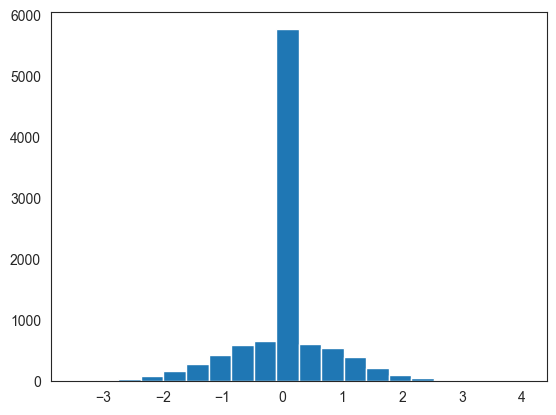

In [4]:
Z = generate_sparse_vector(N_samples, m, sparsity_level)  # sparse code  (m, N_samples)
plt.hist(Z.flatten(), bins=20)

(array([  1.,   3.,  13.,  35., 101., 205., 358., 573., 740., 801., 761.,
        569., 427., 220., 118.,  46.,  20.,   7.,   0.,   2.]),
 array([-3.96778496, -3.55529683, -3.14280869, -2.73032056, -2.31783242,
        -1.90534428, -1.49285615, -1.08036801, -0.66787988, -0.25539174,
         0.15709639,  0.56958453,  0.98207267,  1.3945608 ,  1.80704894,
         2.21953707,  2.63202521,  3.04451335,  3.45700148,  3.86948962,
         4.28197775]),
 <BarContainer object of 20 artists>)

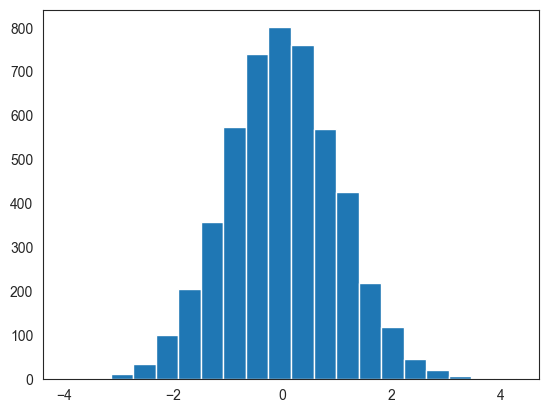

In [5]:
X = Wd @ Z # + np.random.normal(0, 1, (n, N_samples))  # input vector  (n, N_samples)
plt.hist(X.flatten(), bins=20)

# Comparing methods

In [6]:
def plot_run(n_iter, n_iter2, func, sparsity_level, m, N_samples, starts, func_name):
    fig, axs = get_fig_grid_subplots(3, entry_size=(4,4))
    for start in starts:
        Z_arr = np.array(func(Wd, X, sparsity_level, m, N_samples, n_iter=n_iter, start=start))
        losses = [MSE(Z_arr[j], Z) for j in range(n_iter)]
        axs.flat[0].plot(np.arange(1, n_iter+1), losses)
        axs.flat[1].plot(np.arange(n_iter2+1, n_iter+1), losses[n_iter2:])
        axs.flat[2].plot(np.arange(1, n_iter+1), [(Z_arr[j] == 0).mean() for j in range(n_iter)], label=f'{func_name}, start={start}')

    axs.flat[2].plot([1, n_iter+1], [(Z == 0).mean()] * 2, label='real Z')
    axs.flat[2].plot([1, n_iter+1], [sparsity_level] * 2, label='real sparsity level', linestyle='--')
    add_labels(xlabel='itr', ylabel='MSE(real_Z, pred_Z)', ax=axs[0])
    add_labels(xlabel=f'itr>{n_iter2}', ylabel='MSE(real_Z, pred_Z)', ax=axs[1])
    add_labels(xlabel='itr', ylabel='#zeros', ylim=(0, 1), legend=1, ax=axs[2])
    show(fig=fig, title=f'{func_name}')


## Subgradient method

$x_{t+1} = x_t - \eta (2W_d^T (W_dx_t-y) + \lambda z)=x_t - 2\eta W_d^TW_dx_t + 2\eta W_d^Ty - \eta \lambda z, z\in \partial g(x_t)$ \
If $g$ is $\beta$-smooth, we need $\eta=\frac{1}{\beta}$ (to assure convergence). Specifically, norm 2 is smooth with the largest eigenvalue of $W_d^TW_d$,  $\beta = \lambda_{\max}$. So we get \
$x_{t+1} = (I - \frac{2}{\lambda_{\max}} W_d^TW_d)x_t + \frac{2}{\lambda_{\max}} W_d^Ty - \frac{\lambda}{\lambda_{\max}} z, z\in \partial g(x_t)$
Define $S = I - \frac{2}{\lambda_{\max}} W_d^TW_d$ and $W_e=\frac{2}{\lambda_{\max}} W_d^T$. Then \
$x_{t+1} = Sx_t + W_e y - \frac{\lambda}{\lambda_{\max}} z, z\in \partial g(x_t)$


In [7]:
subgradient_method(Wd, X, 0.5, m, N_samples, n_iter=1)

100%|██████████| 1/1 [00:00<00:00, 63.74it/s]


[array([[-0.45657264,  0.18191729,  0.32194643, ..., -1.60499468,
          0.96364771, -0.76435512],
        [-0.56465221,  1.15897574, -0.82018976, ..., -2.11936805,
          2.07861823,  0.3404514 ],
        [ 0.201172  , -1.67062941,  0.9076649 , ...,  0.12725918,
          0.14033396, -1.68114658],
        ...,
        [ 0.99409377,  1.18890239,  0.39423883, ...,  0.55872294,
          0.81802147, -0.03242819],
        [-0.61955537, -0.08670609,  0.36959048, ..., -1.49611484,
         -0.0288857 , -1.75770129],
        [-2.66023055,  0.50891217, -0.33244744, ..., -0.18201981,
          1.01220639, -1.61623223]]),
 array([[-5.01133453e-01, -4.15954398e-01,  5.22539046e-01, ...,
         -1.68189393e+00,  5.53344399e-01, -4.11305001e-01],
        [ 1.79744142e-01,  5.77046968e-01, -1.27317282e+00, ...,
         -1.37090100e+00,  2.05135412e+00,  5.32602284e-01],
        [-1.52624823e-03, -1.10083398e+00,  9.24410598e-01, ...,
          2.21440692e-01, -3.03318928e-01, -1.35525876e+

100%|██████████| 100/100 [00:00<00:00, 1233.03it/s]


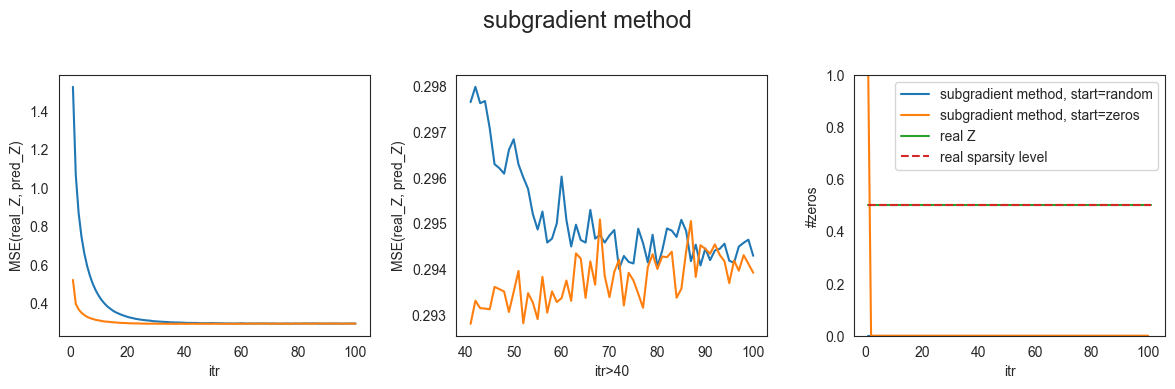

In [8]:
n_iter = 100
n_iter2 = 40
plot_run(n_iter, n_iter2, subgradient_method, sparsity_level, m, N_samples, ['random', 'zeros'], func_name='subgradient method')

## ISTA
ISTA is an iterative algo to solve SC.
Updates the entire code vector in parallel.
Refines the initial guess through a form of mutual inhibition between code component, and component-wise shrinkage.


In [9]:


Z_arr = ISTA(Wd, X, 0.5, m, N_samples, n_iter=200, start='zeros')
Z_arr2 = ISTA_slow(Wd, X, 0.5, m, N_samples, n_iter=200, start='zeros')
assert np.isclose(Z_arr[200], Z_arr2[200]).all()

ISTA(Wd, X, 0.5, m, N_samples, n_iter=2, start='zeros')

100%|██████████| 2/2 [00:00<00:00, 357.08it/s]


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.        , -0.03589689,  0.22988766, ..., -0.20076398,
         -0.08095022, -0.03912977],
        [ 0.06083249,  0.        , -0.1546931 , ..., -0.        ,
          0.32548266, -0.        ],
        [ 0.14571474,  0.32026034,  0.04855193, ..., -0.        ,
         -0.        , -0.14235482],
        ...,
        [ 0.08439422, -0.        ,  0.06013168, ..., -0.        ,
          0.        ,  0.10646282],
        [-0.10878346, -0.03256728,  0.        , ..., -0.        ,
          0.02280826, -0.05651272],
        [-0.03660144, -0.10462352, -0.        , ...,  0.        ,
          0.02134419, -0.00097893]]),
 array([[ 0.        , -0.01776932,  0.31318502, ..., -0.29741718,
         -0.05896341, -0.0487546 ],
        [ 0.06236454, 

100%|██████████| 100/100 [00:00<00:00, 1145.13it/s]


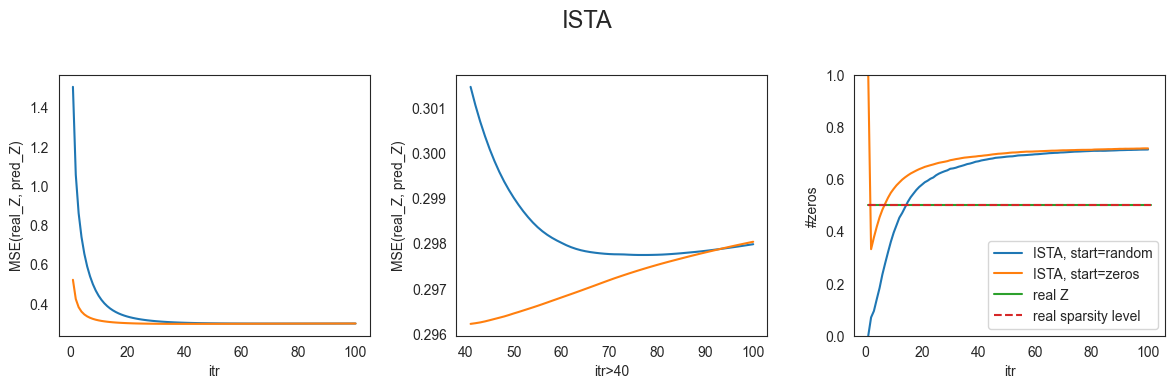

In [10]:
n_iter = 100
n_iter2 = 40
plot_run(n_iter, n_iter2, ISTA, sparsity_level, m, N_samples, ['random', 'zeros'], func_name='ISTA')


## FISTA
The same as ISTA with momentum


In [11]:

FISTA(Wd, X, 0.5, m, N_samples, n_iter=200, start='zeros')


100%|██████████| 200/200 [00:00<00:00, 1244.67it/s]


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 0.        , -0.03589689,  0.22988766, ..., -0.20076398,
         -0.08095022, -0.03912977],
        [ 0.06083249,  0.        , -0.1546931 , ..., -0.        ,
          0.32548266, -0.        ],
        [ 0.14571474,  0.32026034,  0.04855193, ..., -0.        ,
         -0.        , -0.14235482],
        ...,
        [ 0.08439422, -0.        ,  0.06013168, ..., -0.        ,
          0.        ,  0.10646282],
        [-0.10878346, -0.03256728,  0.        , ..., -0.        ,
          0.02280826, -0.05651272],
        [-0.03660144, -0.10462352, -0.        , ...,  0.        ,
          0.02134419, -0.00097893]]),
 array([[ 0.        , -0.01776932,  0.31318502, ..., -0.29741718,
         -0.05896341, -0.0487546 ],
        [ 0.06236454, 

100%|██████████| 100/100 [00:00<00:00, 1789.75it/s]


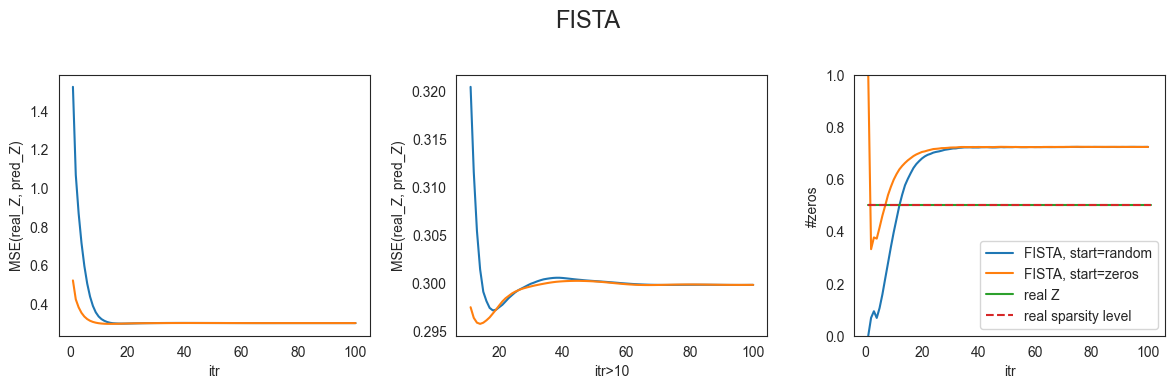

In [20]:
n_iter = 100
n_iter2 = 10
plot_run(n_iter, n_iter2, FISTA, sparsity_level, m, N_samples, ['random', 'zeros'], func_name='FISTA')


## Coordinate Descent (CD)

In [13]:


np.array(CoD(Wd, X, sparsity_level, m, N_samples, n_iter=10, start='zeros'))


100%|██████████| 10/10 [00:00<00:00, 6476.69it/s]


array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[ 0.        , -0.03589689,  0.22988766, ..., -0.20076398,
         -0.08095022, -0.03912977],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.14571474,  0.32026034,  0.04855193, ..., -0.        ,
         -0.        , -0.14235482],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

100%|██████████| 500/500 [00:00<00:00, 7729.93it/s]


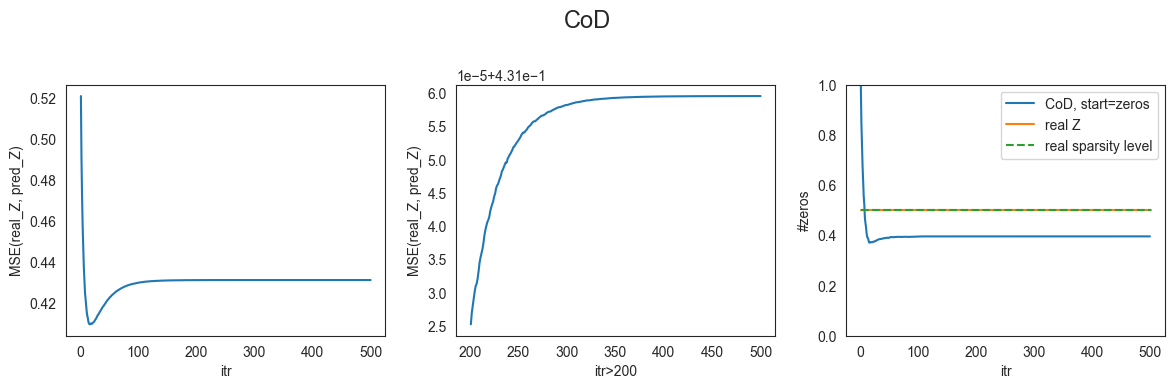

In [14]:
n_iter = 500
n_iter2 = 200
plot_run(n_iter, n_iter2, CoD, sparsity_level, m, N_samples, ['zeros'], func_name='CoD')

## Comparison

100%|██████████| 500/500 [00:00<00:00, 1531.39it/s]


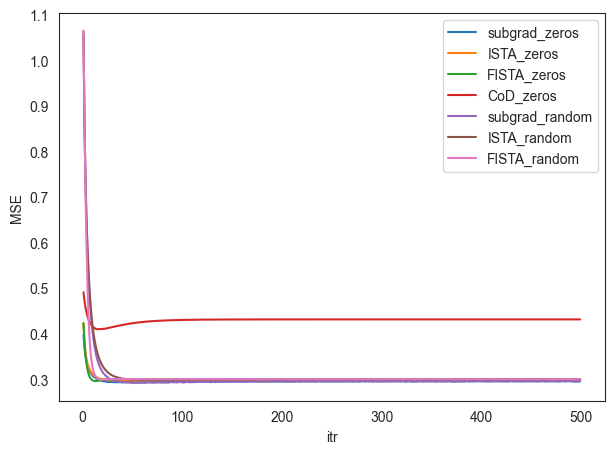

In [15]:
n_iter = 500
fig, axs = plt.subplots(1,1)
for start in ['zeros', 'random']:
    for func_name, func in [('subgrad', subgradient_method), ('ISTA', ISTA), ('FISTA', FISTA), ('CoD', CoD)]:
        if start == 'random' and func_name == 'CoD': continue
        Z_arr = np.array(func(Wd, X, sparsity_level, m, N_samples, n_iter=n_iter, start=start))
        axs.plot(
            np.arange(1, n_iter),
            [MSE(Z_arr[j], Z) for j in range(1, n_iter)],
            label=f'{func_name}_{start}'
        )
    add_labels(xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)


100%|██████████| 500/500 [00:00<00:00, 2223.86it/s]


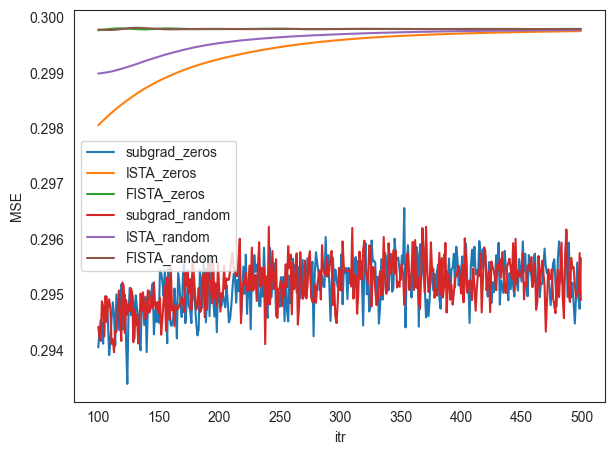

In [16]:
n_iter = 500
fig, axs = plt.subplots(1,1)
for start in ['zeros', 'random']:
    for func_name, func in [('subgrad', subgradient_method), ('ISTA', ISTA), ('FISTA', FISTA)]:
        if start == 'random' and func_name == 'CoD': continue
        Z_arr = np.array(func(Wd, X, sparsity_level, m, N_samples, n_iter=n_iter, start=start))
        axs.plot(
            np.arange(100, n_iter),
            [MSE(Z_arr[j], Z) for j in range(100, n_iter)],
            label=f'{func_name}_{start}'
        )
    add_labels(xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)


100%|██████████| 100/100 [00:00<00:00, 6794.82it/s]


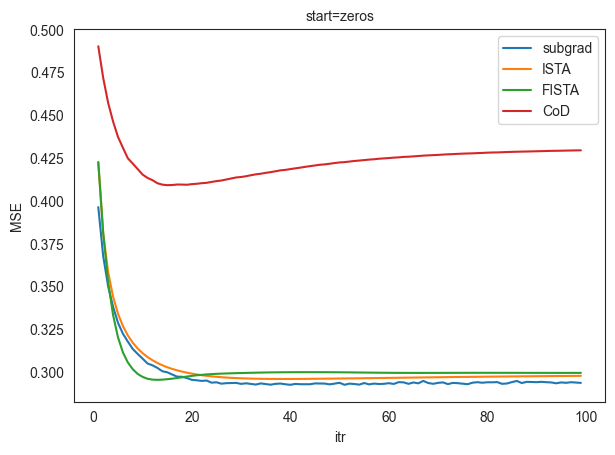

In [17]:
n_iter = 100
fig, axs = plt.subplots(1,1)
start = 'zeros'
for func_name, func in [('subgrad', subgradient_method), ('ISTA', ISTA), ('FISTA', FISTA), ('CoD', CoD)]:
    Z_arr = np.array(func(Wd, X, sparsity_level, m, N_samples, n_iter=n_iter, start=start))
    axs.plot(
        np.arange(1, n_iter),
        [MSE(Z_arr[j], Z) for j in range(1, n_iter)],
        label=f'{func_name}'
    )
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

100%|██████████| 30/30 [00:00<00:00, 4047.90it/s]


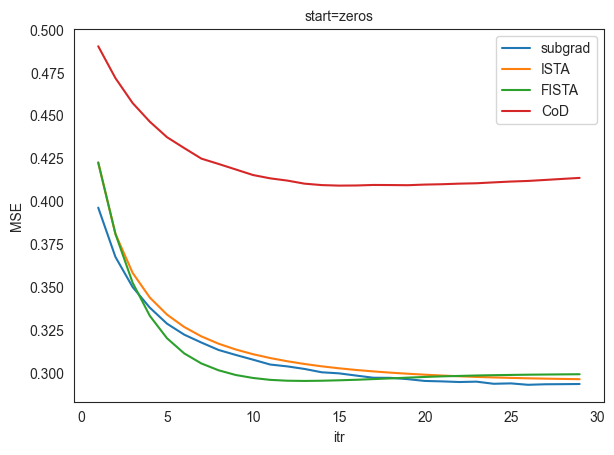

In [23]:
n_iter = 30
fig, axs = plt.subplots(1,1)
start = 'zeros'
for func_name, func in [('subgrad', subgradient_method), ('ISTA', ISTA), ('FISTA', FISTA), ('CoD', CoD)]:
    Z_arr = np.array(func(Wd, X, sparsity_level, m, N_samples, n_iter=n_iter, start=start))
    axs.plot(
        np.arange(1, n_iter),
        [MSE(Z_arr[j], Z) for j in range(1, n_iter)],
        label=f'{func_name}'
    )
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

## Conclusions
- subgradient method is best in terms of MSE, but doesn't give sparse results
- ISTA and FISTA give similar MSE and sparsity level ~ 0.7 > actual levels. FISTA is faster as expected
- CoD gives the worst MSE and sparsity level = 0.4 < actual levels
- Both CoD and FISTA increase which can mean floating issues/ other technical issues

# Approximating the sparse code

## Create synthetic train data

In [41]:
n = 50
m = 100
N_samples = 5000
sparsity_level = 0.5
encoder_losses = {}

In [25]:

Wd = np.random.randn(n, m)  # dictionary matrix  (n, m)
Wd = Wd / np.linalg.norm(Wd, axis=0)
true_Z = generate_sparse_vector(2*N_samples, m, sparsity_level)  # sparse code  (m, N_samples)
X = Wd @ true_Z # + np.random.normal(0, 1, (n, N_samples))  # input vector  (n, N_samples)
Z = ISTA(Wd, X, sparsity_level, m, 2*N_samples, n_iter=1000, start='zeros')[-1]

Z_train = Z[:, :N_samples]
X_train = X[:, :N_samples]
true_Z_train = true_Z[:, :N_samples]
Z_val = Z[:, N_samples:]
X_val = X[:, N_samples:]
true_Z_val = true_Z[:, N_samples:]


100%|██████████| 1000/1000 [00:21<00:00, 46.59it/s]


In [42]:
n_iter = 200
start = 'zeros'
# start = 'random'

regular_losses = {}
for func_name, func in [('subgrad', subgradient_method), ('ISTA', ISTA), ('FISTA', FISTA), ('CoD', CoD)]:
    Z_arr = np.array(func(Wd, X_val, sparsity_level, m, N_samples, n_iter=n_iter, start=start))
    regular_losses[func_name] = [MSE(Z_arr[j], Z_val) for j in range(1, n_iter)]


100%|██████████| 200/200 [00:09<00:00, 20.94it/s]


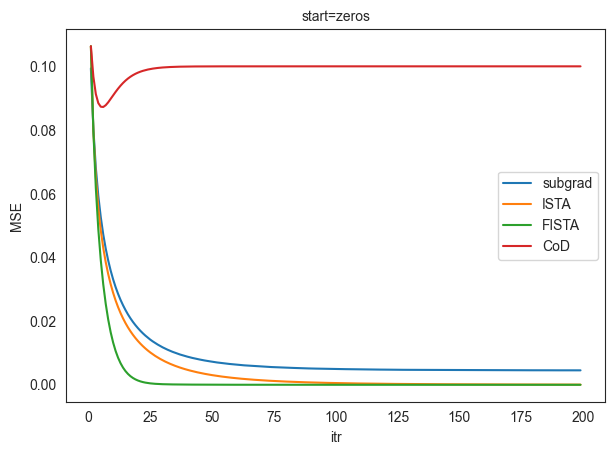

In [43]:

fig, axs = plt.subplots(1,1)
for func_name, loss in regular_losses.items():
    axs.plot(np.arange(1, n_iter), regular_losses[func_name], label=f'{func_name}')
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

## DL Baseline
We define an encoder that receives X and returns Z=g_D(W*X), where W is a trainable matrix and g_D(y) = D * tanh(y) for a trainable diagonal matrix D.
The loss for training W,D will be L(W,D)=mean(Z_true_p - g_D(W*X_p) over samples p=1,...,P, where the true Z for X_p is obtained by running ISTA.

In [44]:

# DL baseline encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # Trainable W matrix (n x m)
        self.W = nn.Linear(input_dim, output_dim, dtype=torch.float32)
        # Trainable diagonal matrix D (m x m)
        self.D_diag = nn.Parameter(torch.ones(output_dim), requires_grad=True)  # Diagonal elements

    def forward(self, X):
        # Forward pass: Z = D * tanh(W*X)
        WX = self.W(X.T)  # W*X  (m,N_samples)
        D = torch.diag(self.D_diag)  # Create a diagonal matrix from the diagonal elements
        Z = torch.matmul(torch.tanh(WX), D).T  # Apply g_D(y) = D * tanh(y)
        return Z
n, m

(50, 100)

In [62]:
n_iter = 500
# Train the model
trained_model_baseline, losses_baseline = train_encoder(
    Encoder(n, m), X_train, Z_train, X_val, Z_val, n_iter=n_iter, learning_rate=0.1, scheduler=None
)

Z_hat = trained_model_baseline(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
encoder_losses['Baseline DL approx'] = MSE(Z_hat, Z_val)

Epoch [491/500], Train loss: 0.0851, Val loss: 0.0869, LR: 0.1000: 100%|██████████| 500/500 [00:02<00:00, 171.15it/s]


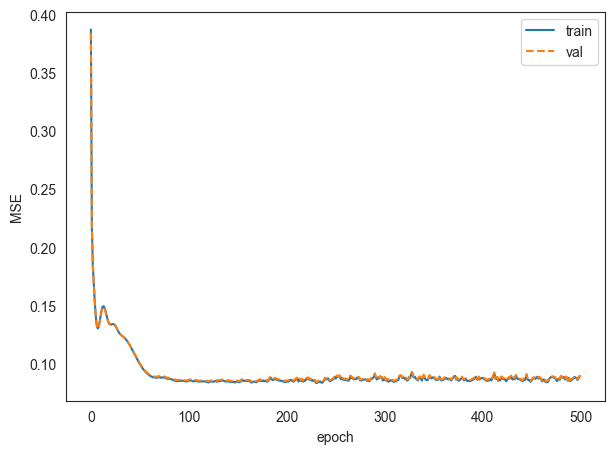

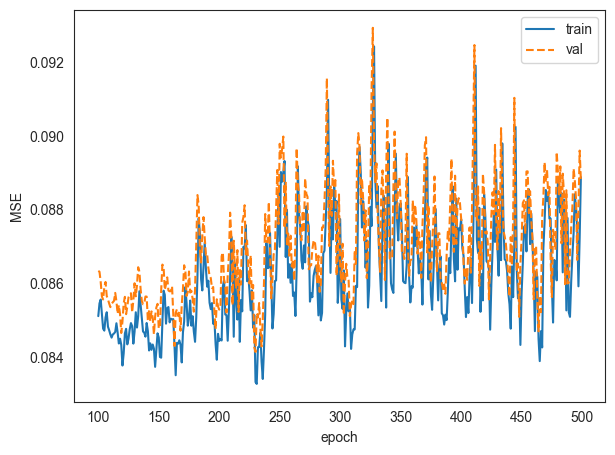

In [63]:
plt.plot(losses_baseline['train'], label='train')
plt.plot(losses_baseline['val'], label='val', linestyle='--')
show(legend=1, xlabel='epoch', ylabel='MSE')
n_start = 100
plt.plot(np.arange(n_start, n_iter), losses_baseline['train'][n_start:], label='train')
plt.plot(np.arange(n_start, n_iter), losses_baseline['val'][n_start+1:], label='val', linestyle='--')
show(legend=1, xlabel='epoch', ylabel='MSE')

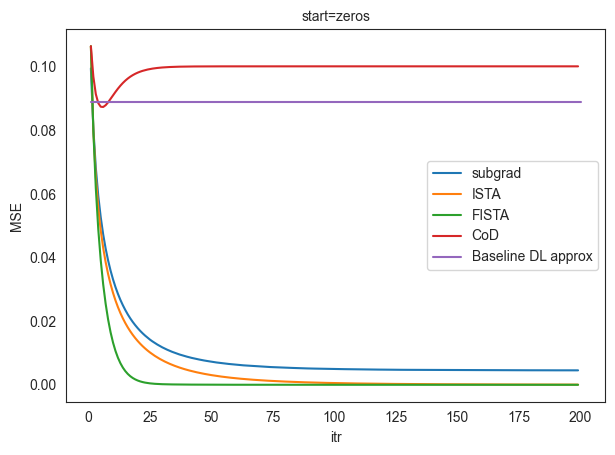

In [64]:
n_iter = 200
fig, axs = plt.subplots(1,1)
for func_name, loss in regular_losses.items():
    axs.plot(np.arange(1, len(regular_losses[func_name])+1), regular_losses[func_name], label=f'{func_name}')

for func_name in ['Baseline DL approx']:
    axs.plot([1, n_iter], [encoder_losses[func_name], encoder_losses[func_name]], label=f'{func_name}')
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

## LISTA

In [65]:

class LISTA(nn.Module):
    def __init__(self, input_dim, output_dim, L=3, W=None, alpha=0.5):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.L = L
        # Trainable W matrix (n x m)
        self.W = nn.Linear(input_dim, output_dim, dtype=torch.float32)
        # Trainable S matrix (m x m)
        self.S = nn.Linear(output_dim, output_dim, dtype=torch.float32)
        # Trainable theta vector (m, 1)
        scale = 1.001 * np.linalg.norm(W, ord=2)**2
        self.theta = nn.Parameter(torch.tensor([alpha / scale] * self.output_dim, dtype=torch.float32))
        self.norm_layer = nn.BatchNorm1d(self.output_dim)

    def shrinkage(self, v):
        return torch.sign(v) * torch.clamp(torch.abs(v) - self.theta, min=0)

    def forward(self, X):
        # Forward pass: Z_t+1 = h_theta(S * Z_t + W * X)) for t=1,...,T, Z0 = 0
        B = self.W(X.T)
        Z = torch.zeros(X.shape[1], self.output_dim, dtype=torch.float32)
        for t in range(self.L):
            Z = self.norm_layer(self.shrinkage(self.S(Z) + B))
        return Z.T


In [66]:
n, m

(50, 100)

Epoch [491/500], Train loss: 0.0329, Val loss: 0.0355, LR: 0.1000: 100%|██████████| 500/500 [00:04<00:00, 102.52it/s]


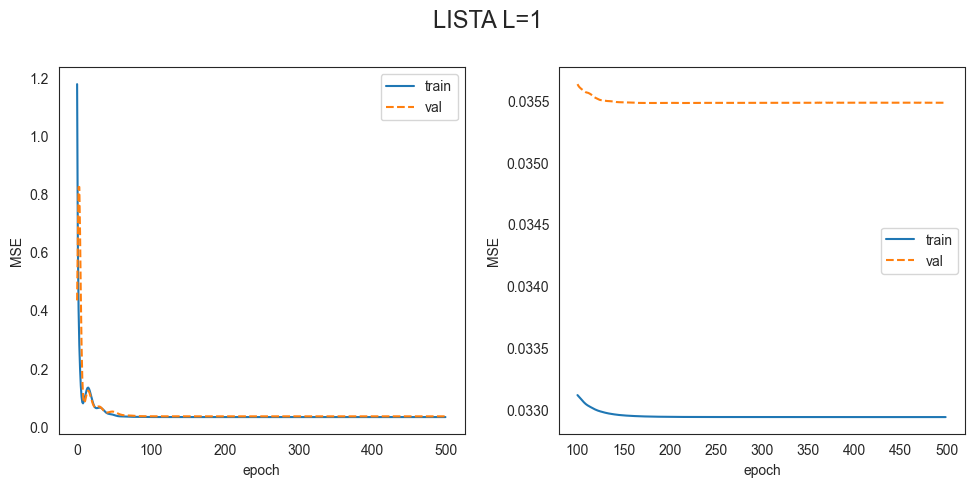

Epoch [491/500], Train loss: 0.0146, Val loss: 0.0468, LR: 0.1000: 100%|██████████| 500/500 [00:07<00:00, 64.63it/s]


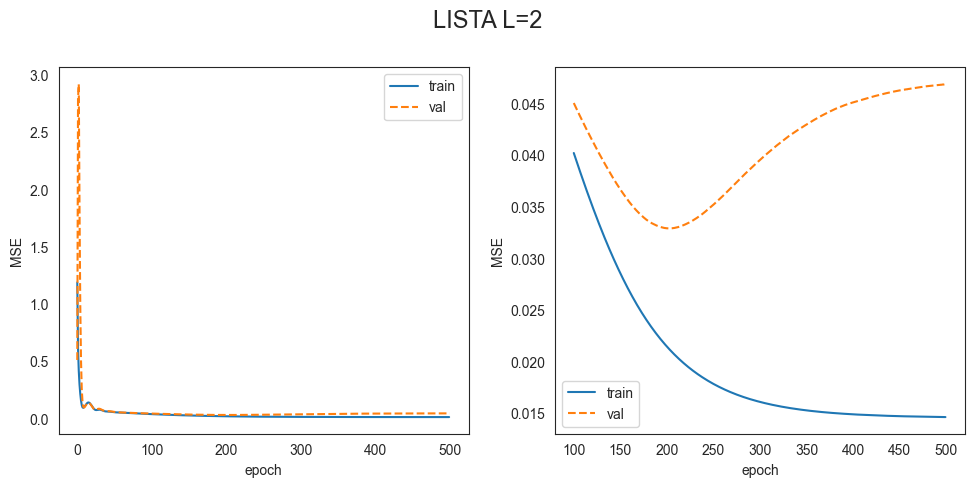

Epoch [491/500], Train loss: 0.0075, Val loss: 0.0327, LR: 0.1000: 100%|██████████| 500/500 [00:10<00:00, 47.18it/s]


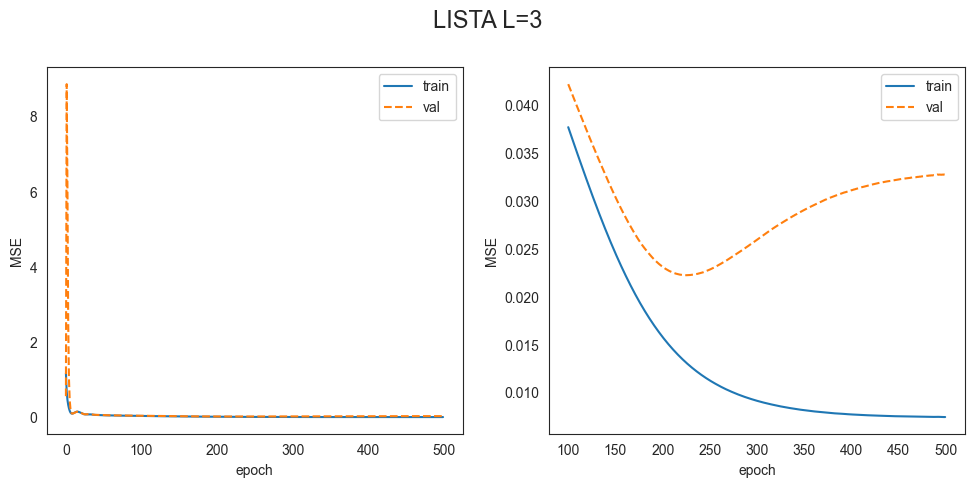

Epoch [491/500], Train loss: 0.0036, Val loss: 0.0176, LR: 0.1000: 100%|██████████| 500/500 [00:14<00:00, 33.56it/s]


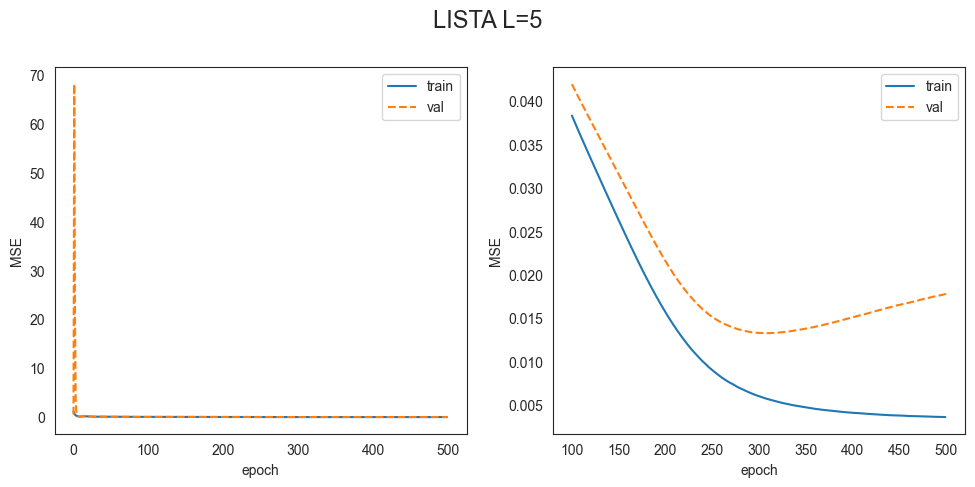

Epoch [491/500], Train loss: 0.0013, Val loss: 0.0052, LR: 0.1000: 100%|██████████| 500/500 [00:25<00:00, 19.80it/s] 


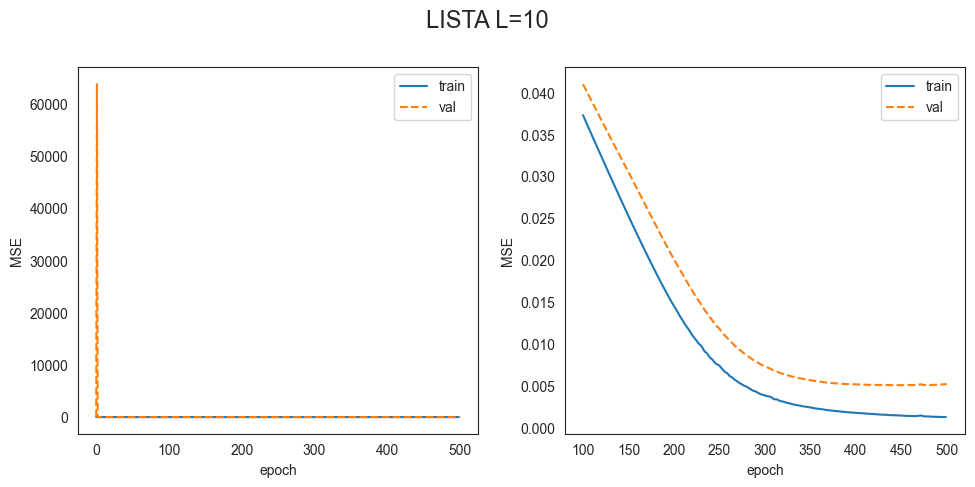

In [74]:

n_iter = 500

for L in [1, 2, 3, 5, 10]:
    trained_model_LISTA, losses_LISTA = train_encoder(
        LISTA(n, m, L=L, W=Wd), X_train, Z_train, X_val, Z_val, n_iter=n_iter, learning_rate=0.1
    )

    Z_hat = trained_model_LISTA(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
    encoder_losses[f'LISTA approx L={L}'] = MSE(Z_hat, Z_val)

    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].plot(losses_LISTA['train'], label='train')
    axs[0].plot(losses_LISTA['val'], label='val', linestyle='--')
    add_labels(legend=1, xlabel='epoch', ylabel='MSE', ax=axs[0])
    start_idx = 100
    axs[1].plot(np.arange(start_idx, n_iter), losses_LISTA['train'][start_idx:], label='train')
    axs[1].plot(np.arange(start_idx, n_iter+1), losses_LISTA['val'][start_idx:], label='val', linestyle='--')
    add_labels(legend=1, xlabel='epoch', ylabel='MSE', ax=axs[1])
    show(fig=fig, title=f'LISTA L={L}')

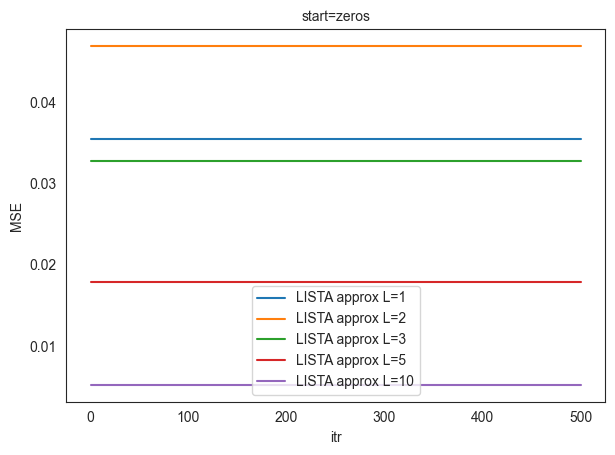

In [75]:
# n_iter = 200
fig, axs = plt.subplots(1,1)
for func_name in [f'LISTA approx L={L}' for L in [1, 2, 3, 5, 10]]:
    axs.plot([1, n_iter], [encoder_losses[func_name], encoder_losses[func_name]], label=f'{func_name}')
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

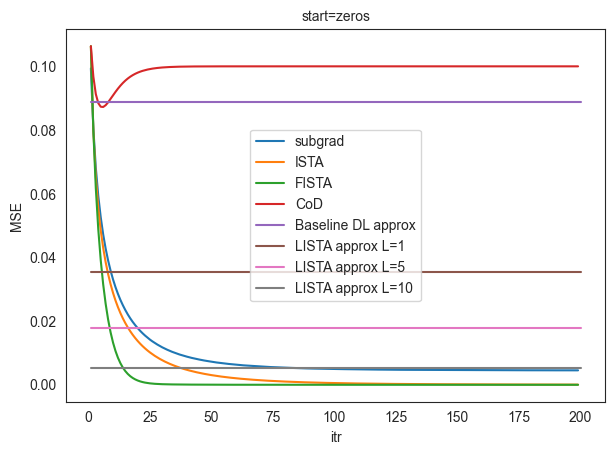

In [76]:
n_iter = 200
fig, axs = plt.subplots(1,1)
for func_name, loss in regular_losses.items():
    axs.plot(np.arange(1, len(regular_losses[func_name])+1), regular_losses[func_name], label=f'{func_name}')

for func_name in ['Baseline DL approx', 'LISTA approx L=1', 'LISTA approx L=5', 'LISTA approx L=10']:
    axs.plot([1, n_iter], [encoder_losses[func_name], encoder_losses[func_name]], label=f'{func_name}')
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

## LISTA with varying params

Epoch [991/1000], Train loss: 0.0332, Val loss: 0.0357, LR: 0.0100: 100%|██████████| 1000/1000 [00:08<00:00, 117.31it/s]


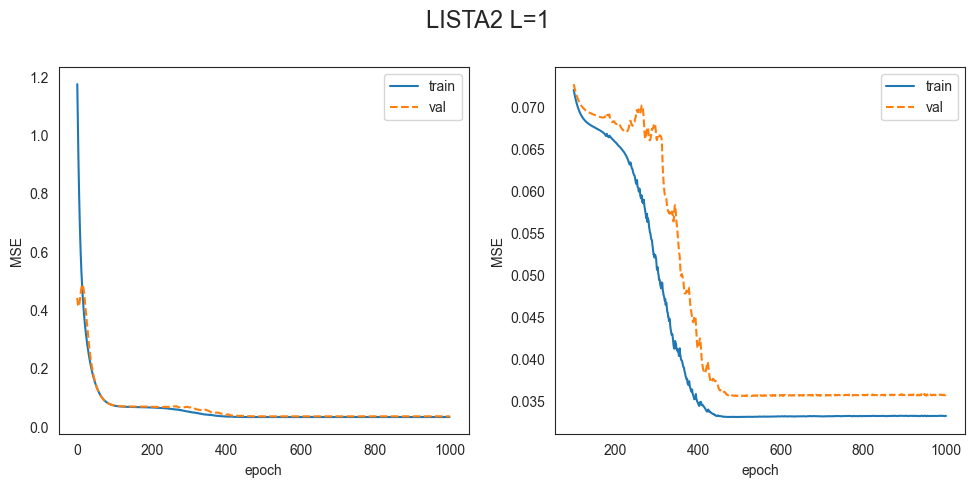

Epoch [991/1000], Train loss: 0.0548, Val loss: 0.0815, LR: 0.0100: 100%|██████████| 1000/1000 [00:15<00:00, 63.05it/s]


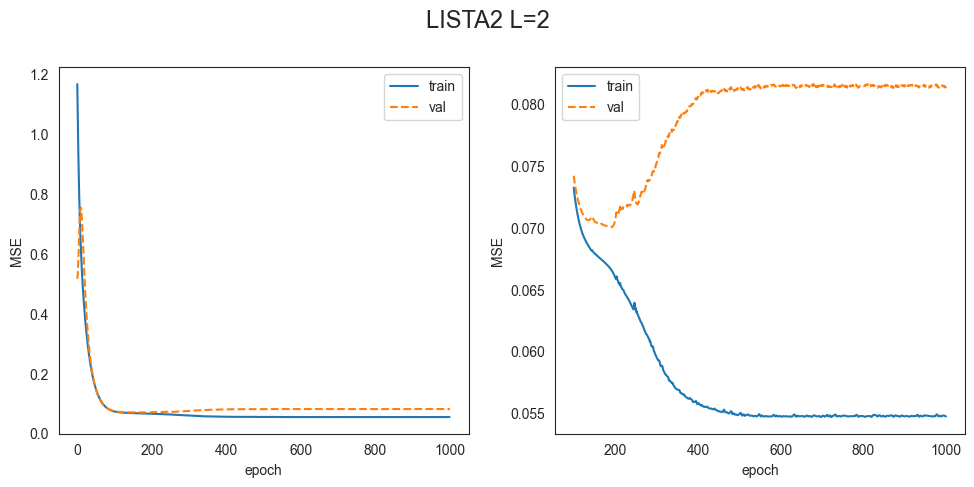

Epoch [991/1000], Train loss: 0.0548, Val loss: 0.0922, LR: 0.0100: 100%|██████████| 1000/1000 [00:23<00:00, 43.05it/s]


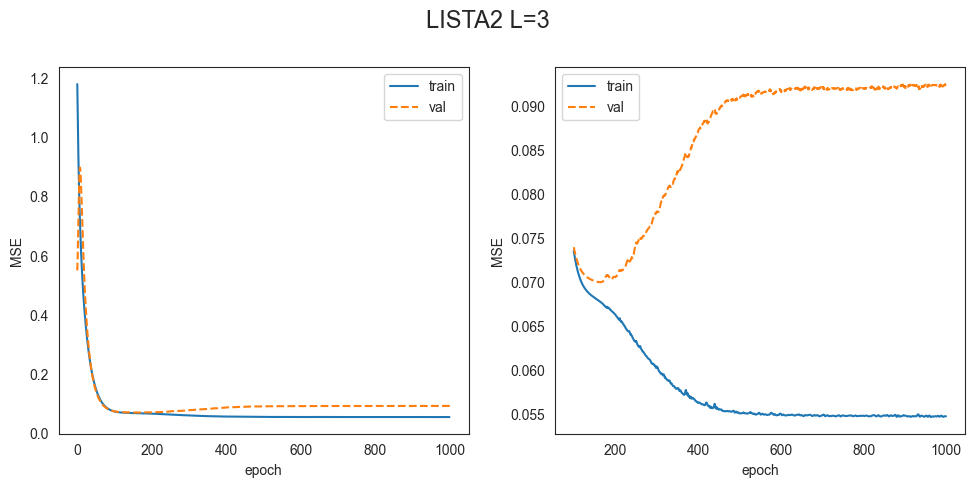

Epoch [991/1000], Train loss: 0.0549, Val loss: 0.0953, LR: 0.0100: 100%|██████████| 1000/1000 [00:33<00:00, 30.20it/s]


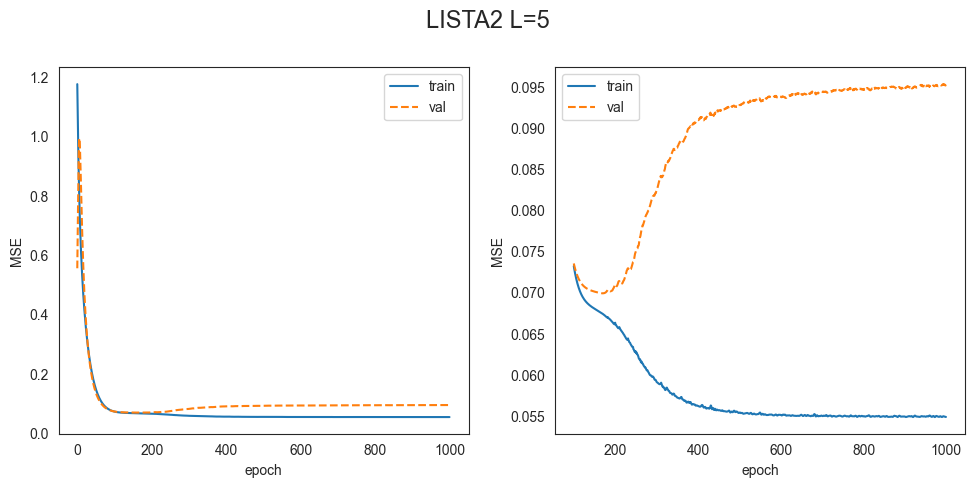

Epoch [991/1000], Train loss: 0.0548, Val loss: 0.0977, LR: 0.0100: 100%|██████████| 1000/1000 [01:03<00:00, 15.69it/s]


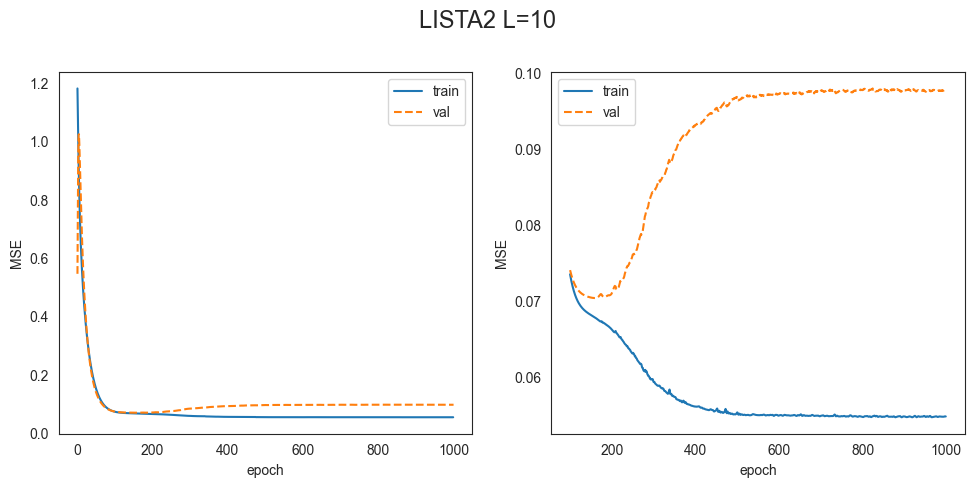

In [80]:

n_iter = 1000

for L in [1, 2, 3, 5, 10]:
    trained_model_LISTA2, losses_LISTA2 = train_encoder(
        LISTA_diff_params(n, m, L=L, W=Wd), X_train, Z_train, X_val, Z_val, n_iter=n_iter, learning_rate=0.01
    )

    Z_hat = trained_model_LISTA2(torch.tensor(X_val, dtype=torch.float32)).detach().numpy()
    encoder_losses[f'LISTA2 approx L={L}'] = MSE(Z_hat, Z_val)


    fig, axs = plt.subplots(1, 2, figsize=(10,5))
    axs[0].plot(losses_LISTA2['train'], label='train')
    axs[0].plot(losses_LISTA2['val'], label='val', linestyle='--')
    add_labels(legend=1, xlabel='epoch', ylabel='MSE', ax=axs[0])
    start_idx = 100
    axs[1].plot(np.arange(start_idx, n_iter), losses_LISTA2['train'][start_idx:], label='train')
    axs[1].plot(np.arange(start_idx, n_iter+1), losses_LISTA2['val'][start_idx:], label='val', linestyle='--')
    add_labels(legend=1, xlabel='epoch', ylabel='MSE', ax=axs[1])
    show(fig=fig, title=f'LISTA2 L={L}')

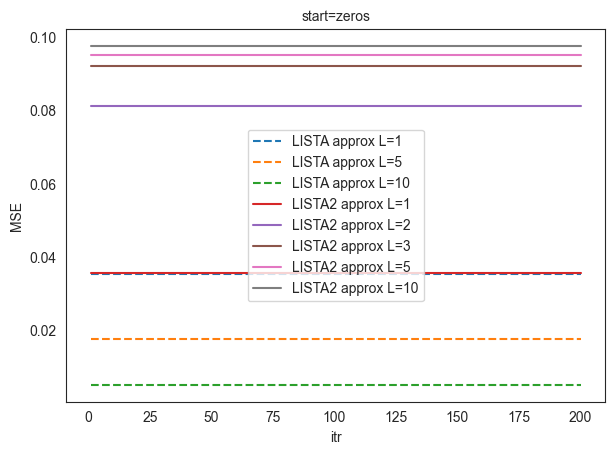

In [84]:
n_iter = 200
fig, axs = plt.subplots(1,1)
# for func_name, loss in regular_losses.items():
#     axs.plot(np.arange(1, len(regular_losses[func_name])+1), regular_losses[func_name], label=f'{func_name}')

for func_name in ['LISTA approx L=1', 'LISTA approx L=5', 'LISTA approx L=10']:
    axs.plot([1, n_iter], [encoder_losses[func_name], encoder_losses[func_name]], label=f'{func_name}', linestyle='--')
for func_name in [f'LISTA2 approx L={L}' for L in [1, 2, 3, 5, 10]]:
    axs.plot([1, n_iter], [encoder_losses[func_name], encoder_losses[func_name]], label=f'{func_name}')
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

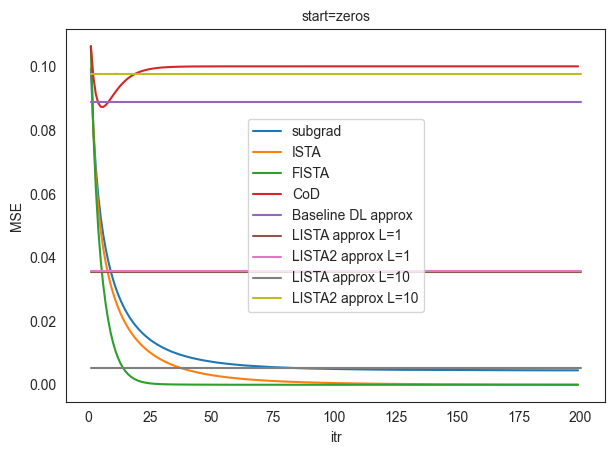

In [85]:
n_iter = 200
fig, axs = plt.subplots(1,1)
for func_name, loss in regular_losses.items():
    axs.plot(np.arange(1, len(regular_losses[func_name])+1), regular_losses[func_name], label=f'{func_name}')

for func_name in ['Baseline DL approx', 'LISTA approx L=1', 'LISTA2 approx L=1', 'LISTA approx L=10', 'LISTA2 approx L=10']:
    axs.plot([1, n_iter], [encoder_losses[func_name], encoder_losses[func_name]], label=f'{func_name}')
add_labels(title=f'start={start}', xlabel='itr', ylabel='MSE', legend=1, ax=axs)
show(fig=fig)

## Conclusions
- Baseline DL approx gives the worst results (exept for CoD)
- LISTA approx gives best approx, improves as number of layers increases. The performance (estimation of ISTA results) is similar to subgradient method
- LISTA with different params gives bad results, probably hyperparams issues (LR?)

# Image Denoising


## get data
In the first set of experiments we compare the performance of different methods on exact sparse code prediction. The data-set consists of a quasi infinite supply image patches of size 10 × 10 pixels, randomly selected from the Berkeley image database. Each patch is preprocessed to remove its mean and normalize its variance. The patches with small standard deviations were discarded. A sparsity coefficient α = 0.5 was used in Equation 1.

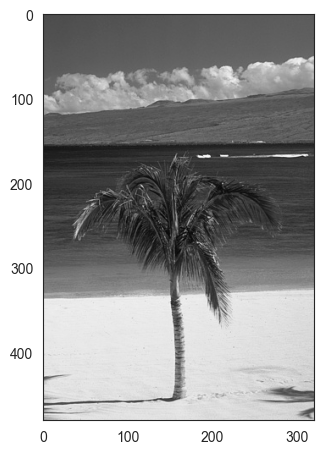

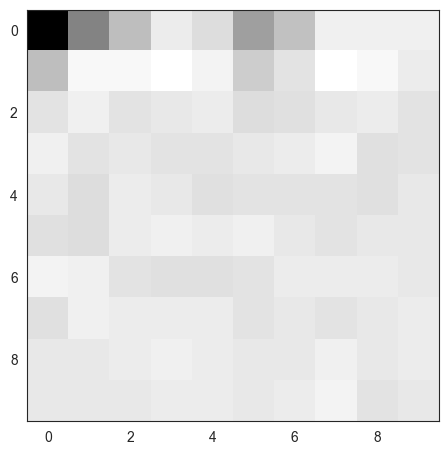

In [86]:
from PIL import Image
import numpy as np
from patchify import patchify
patch_size = (10, 10)
dataset_path = 'BSDS300/images/train/'
image_paths = os.listdir(dataset_path)

img = np.asarray(Image.open(dataset_path+np.random.choice(image_paths)).convert('L'))
plt.imshow(img, cmap='gray')
show()

patches = patchify(img, patch_size).reshape(-1, *patch_size)
plt.imshow(patches[0], cmap='gray')
show()

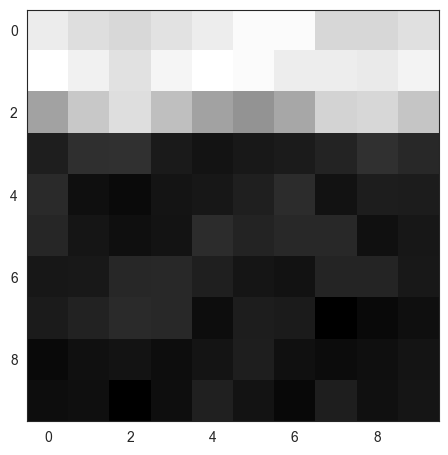

In [87]:
from sklearn.preprocessing import StandardScaler

def get_rand_patch(lower_bound_std=1):
    patch_std = 0
    while patch_std < lower_bound_std:
        img = np.asarray(Image.open(dataset_path+np.random.choice(image_paths)).convert('L'))
        idx0 = np.random.randint(img.shape[0]-patch_size[0])
        idx1 = np.random.randint(img.shape[1]-patch_size[1])
        patch = img[idx0:idx0+patch_size[0], idx1:idx1+patch_size[1]]
        patch_std = patch.std()
    patch = StandardScaler().fit_transform(patch)
    return patch

patch = get_rand_patch()
plt.imshow(patch, cmap='gray')
show()

In [88]:
def data_generator(size): return np.array([get_rand_patch().flatten() for _ in range(size)]).T


## estimate Wd
The dictionary of basis vectors Wd in (1) was trained by iterating the following standard procedure:
    (1) get an image patch from the training set Xp;
    (2) calculate the optimal code Z∗p using the CoD Algorithm 2;
    (3) update Wd with one step of stochastic gradient Wd ← Wd − η * dE_Wd(Xp, Z∗p)/dWd = Wd + η * (Xp − WdZ∗p)Z∗p.T;
    (4) renormalize the column of Wd to unit norm;
    (5) iterate.
The step size was decreased with a 1/t schedule. The procedure resulted in the usual gabor-like filters. We considered two cases, one with m = 100 (complete code) and one with m = 400 (4 times over-complete code).

In [89]:
sparsity_level = 0.5
m = 400
n = patch_size[0]*patch_size[1]

In [90]:

T = 100
Wd, diffs = learn_dictionary_Wd(data_generator, sparsity_level, n, m, T)
Wd

100%|██████████| 1000/1000 [00:00<00:00, 33731.45it/s]


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(T), diffs)
show(xlabel='itr', ylabel='MSE(Wd[t], Wd[t-1])')
plt.plot(np.arange(T)[20:], diffs[20:])
show(xlabel='itr', ylabel='MSE(Wd[t], Wd[t-1])')

In [ ]:
plt.imshow(Wd[:, np.random.randint(m)].reshape(patch_size), cmap='gray')

## train encoder
Once Wd was trained, the LISTA and LCoD encoders were trained as follows:
    (1) get an image patch from the training set Xp;
    (2) calculate the optimal code Z∗p using the CoD Algorithm 2;
    (3) perform fprop through the encoder using either Algorithm 3 or 5 to predict a code;
    (4) perform bprop through the encoder using Algorithms 4 or 6;
    (5) update the encoder parameters using the gradient thereby obtained with equation 6;
    (6) iterate.

We compare the various encoders by measuring the squared error between the code predicted by the encoders and the optimal code Z∗.

The code prediction error for different non-linearities with the baseline
encoder 7 is shown in Table 1. The shrinkage function and the “double tanh” perform similarly, and are
both considerably better than the D tanh non-linearity
of (Kavukcuoglu et al., 2008). Interestingly, they are
also much better than FISTA with 1 iteration, even
though the computation is considerably less.

In [ ]:

T = 100
learning_rate = 0.001
n = patch_size[0]*patch_size[1]
model, losses = train_encoder_online(data_generator, Encoder(n, m), Wd, sparsity_level, n, m, T, learning_rate=1, N_val=50, batch_size=1)

In [ ]:
plt.plot(np.arange(T), losses['train'])
plt.plot(np.arange(T+1), losses['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

In [ ]:
model, losses = train_encoder_online(data_generator, LISTA(n, m, L=10, W=Wd), Wd, sparsity_level, n, m, T, learning_rate=1, N_val=50, batch_size=1)

In [ ]:
plt.plot(np.arange(T), losses['train'])
plt.plot(np.arange(T+1), losses['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

In [ ]:
model, losses = train_encoder_online(data_generator, LISTA(n, m, L=1, W=Wd), Wd, sparsity_level, n, m, T, learning_rate=1, N_val=50, batch_size=1)

In [ ]:
plt.plot(np.arange(T), losses['train'])
plt.plot(np.arange(T+1), losses['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

## estimate Wd with batches

In [91]:
batch_size = 50
T = 100
Wd, diffs = learn_dictionary_Wd(data_generator, sparsity_level, n, m, T, batch_size=batch_size)
Wd

100%|██████████| 1000/1000 [00:00<00:00, 2259.67it/s]


array([[ 0.06448746, -0.02472418, -0.07845139, ..., -0.03252648,
        -0.01105674,  0.20495518],
       [-0.06563646, -0.1274049 , -0.09868394, ..., -0.0551929 ,
         0.01062672,  0.10263793],
       [-0.0752819 , -0.18009874,  0.00351947, ...,  0.00748302,
         0.01498126,  0.06339832],
       ...,
       [ 0.01960799, -0.06314344, -0.03180346, ...,  0.09698254,
         0.06807902,  0.14797277],
       [-0.06435633,  0.01906848, -0.14041904, ...,  0.14060965,
        -0.03401301, -0.01866393],
       [-0.04525364, -0.11769044,  0.0068231 , ..., -0.041687  ,
        -0.0200364 ,  0.01760893]])

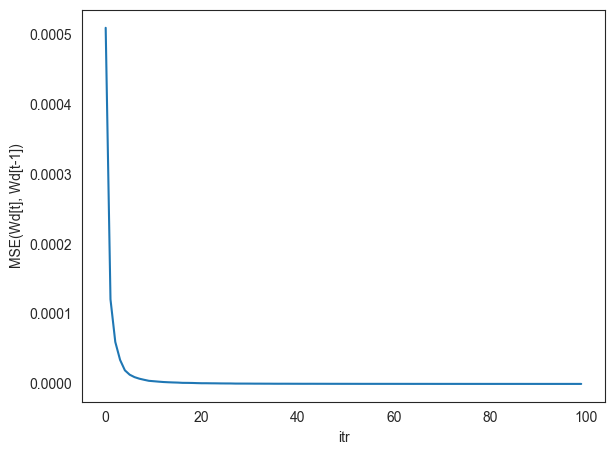

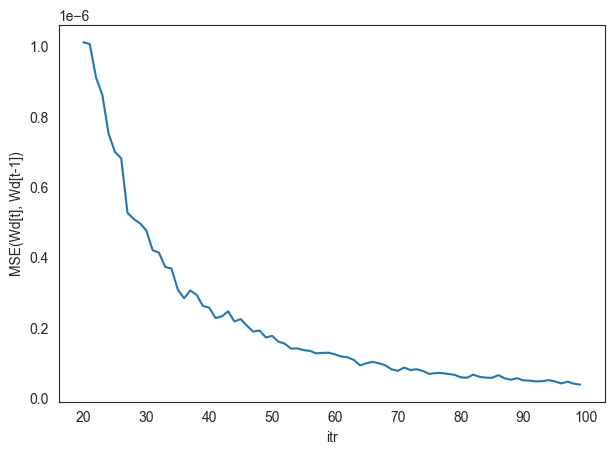

In [92]:
plt.plot(np.arange(T), diffs)
show(xlabel='itr', ylabel='MSE(Wd[t], Wd[t-1])')
plt.plot(np.arange(T)[20:], diffs[20:])
show(xlabel='itr', ylabel='MSE(Wd[t], Wd[t-1])')

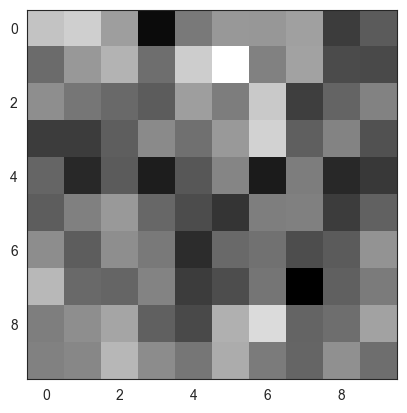

In [93]:
plt.imshow(Wd[:, np.random.randint(m)].reshape(patch_size), cmap='gray')

## train encoder with batches

In [95]:
losses = {}

In [96]:
T = 100
model, losses['baseline'] = train_encoder_online(data_generator, Encoder(n, m), Wd, sparsity_level, n, m, T, learning_rate=0.1, N_val=50, batch_size=batch_size)

100%|██████████| 1000/1000 [00:00<00:00, 2435.63it/s]
Epoch [91/1000], Train loss: 0.0685, Val loss: 0.0681, LR: 0.0100: 100%|██████████| 100/100 [01:03<00:00,  1.56it/s]


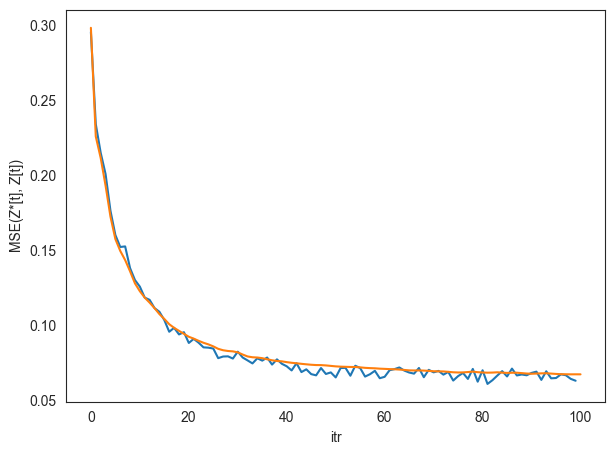

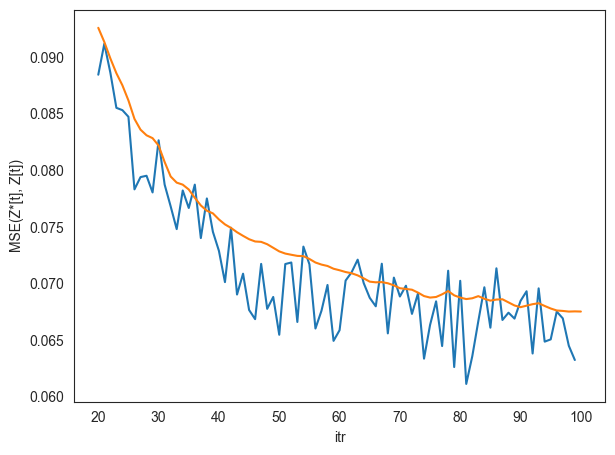

In [97]:
plt.plot(np.arange(T), losses['baseline']['train'])
plt.plot(np.arange(T+1), losses['baseline']['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')
plt.plot(np.arange(T)[20:], losses['baseline']['train'][20:])
plt.plot(np.arange(T+1)[20:], losses['baseline']['val'][20:])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

In [99]:

model, losses['LISTA L=1'] = train_encoder_online(data_generator, LISTA(n, m, L=1, W=Wd), Wd, sparsity_level, n, m, T, learning_rate=1, N_val=50, batch_size=batch_size)

100%|██████████| 1000/1000 [00:00<00:00, 2756.33it/s]
Epoch [91/1000], Train loss: 0.0701, Val loss: 0.0718, LR: 1.0000: 100%|██████████| 100/100 [01:10<00:00,  1.41it/s]


In [ ]:
plt.plot(np.arange(T), losses['LISTA L=1']['train'])
plt.plot(np.arange(T+1), losses['LISTA L=1']['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')
plt.plot(np.arange(T)[20:], losses['LISTA L=1']['train'][20:])
plt.plot(np.arange(T+1)[20:], losses['LISTA L=1']['val'][20:])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

In [ ]:

model, losses['LISTA L=10'] = train_encoder_online(data_generator, LISTA(n, m, L=10, W=Wd), Wd, sparsity_level, n, m, T, learning_rate=1, N_val=50, batch_size=batch_size)

In [ ]:
plt.plot(np.arange(T), losses['LISTA L=10']['train'])
plt.plot(np.arange(T+1), losses['LISTA L=10']['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')
plt.plot(np.arange(T)[20:], losses['LISTA L=10']['train'][20:])
plt.plot(np.arange(T+1)[20:], losses['LISTA L=10']['val'][20:])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

In [ ]:

model, losses = train_encoder_online(data_generator, LISTA_diff_params(n, m, L=1, W=Wd), Wd, sparsity_level, n, m, T, learning_rate=1, N_val=50, batch_size=batch_size)

In [ ]:
plt.plot(np.arange(T), losses['train'])
plt.plot(np.arange(T+1), losses['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')
plt.plot(np.arange(T)[20:], losses['train'][20:])
plt.plot(np.arange(T+1)[20:], losses['val'][20:])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

In [ ]:

model, losses = train_encoder_online(data_generator, LISTA_diff_params(n, m, L=10, W=Wd), Wd, sparsity_level, n, m, T, learning_rate=1, N_val=50, batch_size=batch_size)

In [ ]:
plt.plot(np.arange(T), losses['train'])
plt.plot(np.arange(T+1), losses['val'])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')
plt.plot(np.arange(T)[20:], losses['train'][20:])
plt.plot(np.arange(T+1)[20:], losses['val'][20:])
show(xlabel='itr', ylabel='MSE(Z*[t], Z[t])')

## Future
- Fix issues
- Other iterative methods for expression data? specifically anything with EM and a complicated E-step -
        can we replace the E step with an NN, and then the M-step is an iterative method that can be applied repeatedly?
- Other similar problems?

- Stochastic dynamical systems?